# DCGAN - Min-Max GAN
MMGAN指的是通过 $\log(1-D(x))$，即优化Jason-Shannon散度的GAN


# Import Necessary Packages
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- One-side Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
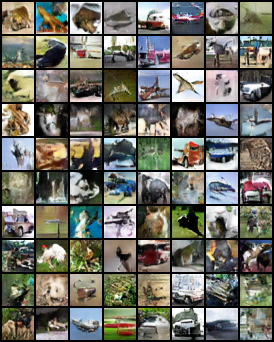


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

import numpy as np

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 200
softlabel = 0.1 

ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 2e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  9019
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator Definitions (Vanilla DCGAN Fashion)
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake).

Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

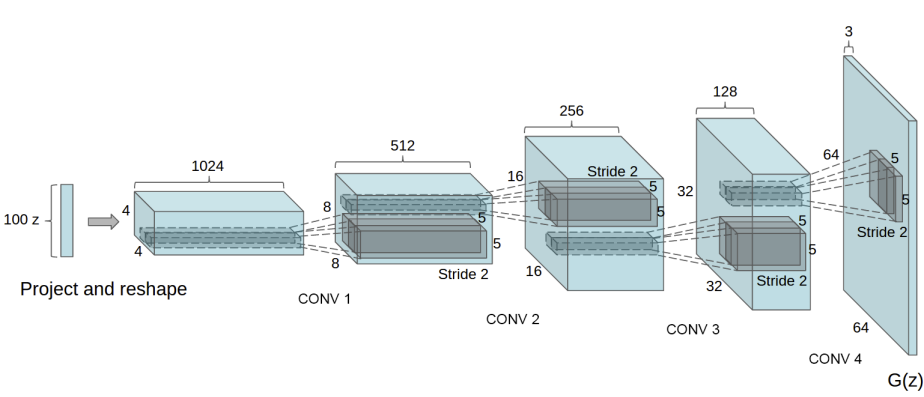

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

  0%|          | 0/200 [00:00<?, ?it/s]

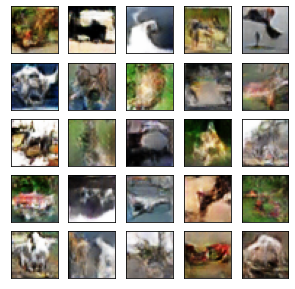

Epoch[0/200],d_loss:0.798432,g_loss:0.795201 D real: 0.690799,D fake: 0.179641
Epoch[0/200],d_loss:0.827223,g_loss:0.708841 D real: 0.670269,D fake: 0.240522
Epoch[0/200],d_loss:0.782102,g_loss:0.791747 D real: 0.734856,D fake: 0.179435
Epoch[0/200],d_loss:0.835094,g_loss:0.749689 D real: 0.646313,D fake: 0.213993


  0%|          | 1/200 [00:23<1:18:06, 23.55s/it]

Epoch[1/200],d_loss:0.799442,g_loss:0.815307 D real: 0.675039,D fake: 0.160359
Epoch[1/200],d_loss:0.712570,g_loss:0.800831 D real: 0.690317,D fake: 0.173510
Epoch[1/200],d_loss:0.870907,g_loss:0.484795 D real: 0.624519,D fake: 0.376146
Epoch[1/200],d_loss:0.822784,g_loss:0.806807 D real: 0.681630,D fake: 0.170618


  1%|          | 2/200 [00:43<1:14:25, 22.55s/it]

Epoch[2/200],d_loss:0.765183,g_loss:0.675123 D real: 0.666179,D fake: 0.259639
Epoch[2/200],d_loss:1.059890,g_loss:0.861119 D real: 0.718206,D fake: 0.125865
Epoch[2/200],d_loss:0.866973,g_loss:0.659805 D real: 0.542736,D fake: 0.275288
Epoch[2/200],d_loss:0.817417,g_loss:0.724913 D real: 0.653212,D fake: 0.231153


  2%|▏         | 3/200 [01:07<1:15:18, 22.94s/it]

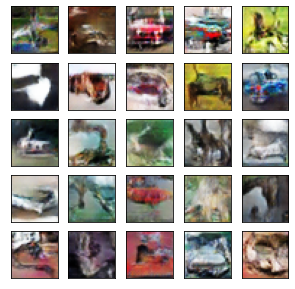

Epoch[3/200],d_loss:0.950454,g_loss:0.353681 D real: 0.482121,D fake: 0.443544
Epoch[3/200],d_loss:0.796083,g_loss:0.820287 D real: 0.774843,D fake: 0.157519
Epoch[3/200],d_loss:0.805798,g_loss:0.651194 D real: 0.616560,D fake: 0.277515
Epoch[3/200],d_loss:0.928178,g_loss:0.618424 D real: 0.548995,D fake: 0.301524


  2%|▏         | 4/200 [01:35<1:19:38, 24.38s/it]

Epoch[4/200],d_loss:0.868427,g_loss:0.683060 D real: 0.654756,D fake: 0.255949
Epoch[4/200],d_loss:0.887291,g_loss:0.642068 D real: 0.635015,D fake: 0.286461
Epoch[4/200],d_loss:0.888042,g_loss:0.711489 D real: 0.615147,D fake: 0.239411
Epoch[4/200],d_loss:0.897661,g_loss:0.580356 D real: 0.521864,D fake: 0.321725


  2%|▎         | 5/200 [02:02<1:21:41, 25.13s/it]

Epoch[5/200],d_loss:0.757796,g_loss:0.792818 D real: 0.719603,D fake: 0.179562
Epoch[5/200],d_loss:0.747760,g_loss:0.772813 D real: 0.619204,D fake: 0.193807
Epoch[5/200],d_loss:0.823631,g_loss:0.685487 D real: 0.586720,D fake: 0.253616
Epoch[5/200],d_loss:0.727570,g_loss:0.757620 D real: 0.650188,D fake: 0.203240


  3%|▎         | 6/200 [02:27<1:21:05, 25.08s/it]

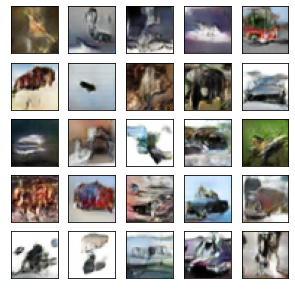

Epoch[6/200],d_loss:0.805442,g_loss:0.846013 D real: 0.743049,D fake: 0.136998
Epoch[6/200],d_loss:0.771806,g_loss:0.721465 D real: 0.598655,D fake: 0.233403
Epoch[6/200],d_loss:0.801457,g_loss:0.849306 D real: 0.724804,D fake: 0.135942
Epoch[6/200],d_loss:0.765880,g_loss:0.782787 D real: 0.661012,D fake: 0.189190


  4%|▎         | 7/200 [02:58<1:26:19, 26.83s/it]

Epoch[7/200],d_loss:1.043650,g_loss:0.906114 D real: 0.705468,D fake: 0.086395
Epoch[7/200],d_loss:0.801960,g_loss:0.792743 D real: 0.744446,D fake: 0.174552
Epoch[7/200],d_loss:0.842596,g_loss:0.588233 D real: 0.566388,D fake: 0.321395
Epoch[7/200],d_loss:0.776848,g_loss:0.738552 D real: 0.718352,D fake: 0.220047


  4%|▍         | 8/200 [03:18<1:19:16, 24.78s/it]

Epoch[8/200],d_loss:0.983616,g_loss:0.841744 D real: 0.740840,D fake: 0.138086
Epoch[8/200],d_loss:0.740054,g_loss:0.741775 D real: 0.679515,D fake: 0.218161
Epoch[8/200],d_loss:0.888571,g_loss:0.848858 D real: 0.719151,D fake: 0.135330
Epoch[8/200],d_loss:2.126919,g_loss:0.267223 D real: 0.124904,D fake: 0.469367


  4%|▍         | 9/200 [03:43<1:19:05, 24.85s/it]

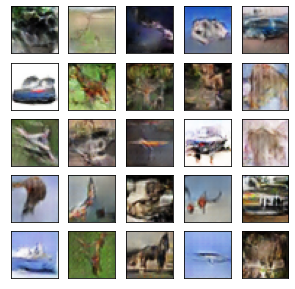

Epoch[9/200],d_loss:0.785804,g_loss:0.921780 D real: 0.828037,D fake: 0.073740
Epoch[9/200],d_loss:0.716477,g_loss:0.675342 D real: 0.673964,D fake: 0.259621
Epoch[9/200],d_loss:0.777543,g_loss:0.698695 D real: 0.675614,D fake: 0.248265
Epoch[9/200],d_loss:0.784897,g_loss:0.822785 D real: 0.768961,D fake: 0.156519


  5%|▌         | 10/200 [04:13<1:23:40, 26.42s/it]

Epoch[10/200],d_loss:0.805546,g_loss:0.472525 D real: 0.528609,D fake: 0.386287
Epoch[10/200],d_loss:0.799463,g_loss:0.809698 D real: 0.732649,D fake: 0.166128
Epoch[10/200],d_loss:0.902130,g_loss:0.607426 D real: 0.529642,D fake: 0.301258
Epoch[10/200],d_loss:0.796278,g_loss:0.631829 D real: 0.660753,D fake: 0.284314


  6%|▌         | 11/200 [04:37<1:20:59, 25.71s/it]

Epoch[11/200],d_loss:0.703402,g_loss:0.776710 D real: 0.710016,D fake: 0.186881
Epoch[11/200],d_loss:0.826763,g_loss:0.800920 D real: 0.592471,D fake: 0.173414
Epoch[11/200],d_loss:0.801905,g_loss:0.874424 D real: 0.724761,D fake: 0.115407
Epoch[11/200],d_loss:0.818906,g_loss:0.584282 D real: 0.602250,D fake: 0.307454


  6%|▌         | 12/200 [04:58<1:16:00, 24.26s/it]

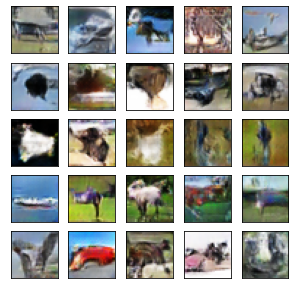

Epoch[12/200],d_loss:0.802767,g_loss:0.634728 D real: 0.579763,D fake: 0.285998
Epoch[12/200],d_loss:0.730840,g_loss:0.724717 D real: 0.597338,D fake: 0.225655
Epoch[12/200],d_loss:0.703778,g_loss:0.838105 D real: 0.720950,D fake: 0.141066
Epoch[12/200],d_loss:0.664119,g_loss:0.789467 D real: 0.784087,D fake: 0.175714


  6%|▋         | 13/200 [05:23<1:16:44, 24.62s/it]

Epoch[13/200],d_loss:0.852478,g_loss:0.686278 D real: 0.570632,D fake: 0.252970
Epoch[13/200],d_loss:0.748335,g_loss:0.761539 D real: 0.667114,D fake: 0.200625
Epoch[13/200],d_loss:0.811699,g_loss:0.544296 D real: 0.548990,D fake: 0.338711
Epoch[13/200],d_loss:1.381651,g_loss:0.987340 D real: 0.854028,D fake: 0.012524


  7%|▋         | 14/200 [05:48<1:16:36, 24.71s/it]

Epoch[14/200],d_loss:0.695829,g_loss:0.861224 D real: 0.775185,D fake: 0.123691
Epoch[14/200],d_loss:0.766376,g_loss:0.823196 D real: 0.730886,D fake: 0.152950
Epoch[14/200],d_loss:0.731908,g_loss:0.722038 D real: 0.700556,D fake: 0.226606
Epoch[14/200],d_loss:0.780025,g_loss:0.679007 D real: 0.648353,D fake: 0.247831


  8%|▊         | 15/200 [06:14<1:17:05, 25.00s/it]

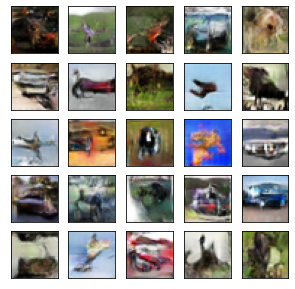

Epoch[15/200],d_loss:0.817130,g_loss:0.846775 D real: 0.801418,D fake: 0.135767
Epoch[15/200],d_loss:0.684511,g_loss:0.620673 D real: 0.705181,D fake: 0.293166
Epoch[15/200],d_loss:0.642421,g_loss:0.754692 D real: 0.760299,D fake: 0.203437
Epoch[15/200],d_loss:0.788456,g_loss:0.753553 D real: 0.550723,D fake: 0.205133


  8%|▊         | 16/200 [06:43<1:20:13, 26.16s/it]

Epoch[16/200],d_loss:0.738363,g_loss:0.786527 D real: 0.639472,D fake: 0.175675
Epoch[16/200],d_loss:0.674111,g_loss:0.775484 D real: 0.689804,D fake: 0.190063
Epoch[16/200],d_loss:3.644814,g_loss:0.995762 D real: 0.938654,D fake: 0.004189
Epoch[16/200],d_loss:0.794789,g_loss:0.787818 D real: 0.768538,D fake: 0.178532


  8%|▊         | 17/200 [07:08<1:19:04, 25.93s/it]

Epoch[17/200],d_loss:0.689607,g_loss:0.793383 D real: 0.744454,D fake: 0.177632
Epoch[17/200],d_loss:0.633276,g_loss:0.843963 D real: 0.833283,D fake: 0.139079
Epoch[17/200],d_loss:0.712033,g_loss:0.740887 D real: 0.724823,D fake: 0.214864
Epoch[17/200],d_loss:0.742873,g_loss:0.754047 D real: 0.632662,D fake: 0.208611


  9%|▉         | 18/200 [07:30<1:15:02, 24.74s/it]

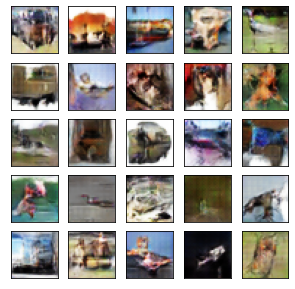

Epoch[18/200],d_loss:1.968061,g_loss:0.966278 D real: 0.907426,D fake: 0.032138
Epoch[18/200],d_loss:0.806546,g_loss:0.849344 D real: 0.722195,D fake: 0.132858
Epoch[18/200],d_loss:0.735715,g_loss:0.851207 D real: 0.730848,D fake: 0.133540
Epoch[18/200],d_loss:0.658197,g_loss:0.665414 D real: 0.680982,D fake: 0.264286


 10%|▉         | 19/200 [07:55<1:14:33, 24.71s/it]

Epoch[19/200],d_loss:0.678888,g_loss:0.804911 D real: 0.877910,D fake: 0.168507
Epoch[19/200],d_loss:0.694117,g_loss:0.749086 D real: 0.662572,D fake: 0.207384
Epoch[19/200],d_loss:0.739668,g_loss:0.866495 D real: 0.853508,D fake: 0.119775
Epoch[19/200],d_loss:0.870969,g_loss:0.462556 D real: 0.514813,D fake: 0.384962


 10%|█         | 20/200 [08:20<1:15:00, 25.00s/it]

Epoch[20/200],d_loss:0.751490,g_loss:0.708615 D real: 0.574882,D fake: 0.234481
Epoch[20/200],d_loss:0.748681,g_loss:0.679674 D real: 0.570971,D fake: 0.254707
Epoch[20/200],d_loss:0.779021,g_loss:0.721851 D real: 0.628525,D fake: 0.225608
Epoch[20/200],d_loss:1.031615,g_loss:0.930391 D real: 0.808244,D fake: 0.065794


 10%|█         | 21/200 [08:44<1:13:26, 24.62s/it]

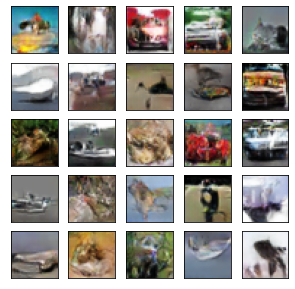

Epoch[21/200],d_loss:0.685534,g_loss:0.717279 D real: 0.650878,D fake: 0.233821
Epoch[21/200],d_loss:0.654371,g_loss:0.782306 D real: 0.734879,D fake: 0.185549
Epoch[21/200],d_loss:0.781756,g_loss:0.627721 D real: 0.555484,D fake: 0.288366
Epoch[21/200],d_loss:0.668644,g_loss:0.739372 D real: 0.694154,D fake: 0.216970


 11%|█         | 22/200 [09:11<1:15:09, 25.33s/it]

Epoch[22/200],d_loss:0.734321,g_loss:0.711795 D real: 0.625611,D fake: 0.235355
Epoch[22/200],d_loss:0.684025,g_loss:0.747813 D real: 0.677624,D fake: 0.207746
Epoch[22/200],d_loss:0.738844,g_loss:0.880068 D real: 0.758757,D fake: 0.108256
Epoch[22/200],d_loss:0.718274,g_loss:0.771778 D real: 0.696249,D fake: 0.195524


 12%|█▏        | 23/200 [09:35<1:13:31, 24.92s/it]

Epoch[23/200],d_loss:0.639086,g_loss:0.814733 D real: 0.678228,D fake: 0.160263
Epoch[23/200],d_loss:0.737946,g_loss:0.851206 D real: 0.778277,D fake: 0.132502
Epoch[23/200],d_loss:0.686099,g_loss:0.826391 D real: 0.631380,D fake: 0.152877
Epoch[23/200],d_loss:0.735586,g_loss:0.909268 D real: 0.815677,D fake: 0.082030


In [ ]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dim,1,1).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
            k += 1
        plt.show()
        
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images


        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img).view(-1,1)
        d_loss_real = torch.mean((1-softlabel) * torch.log(real_out + 1e-8) + softlabel * torch.log(1 - real_out + 1e-8))
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        #z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        d_loss_fake = torch.mean(torch.log(1 - fake_out + 1e-8))
        
        d_loss = -1 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D_losses.append(d_loss)
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = 1 + torch.mean(torch.log(1 - fake_out + 1e-8))
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))'''

# Visualization

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区

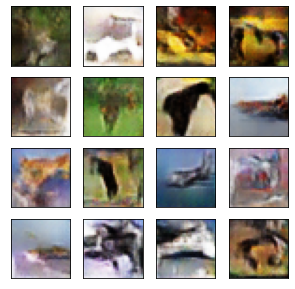

In [27]:
G.eval()
z = torch.randn(16, z_dim,1,1).to(device)
img = G(z)
plt.close()
grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
    k += 1
plt.show()

In [25]:
np.shape(temp_img.transpose((1,2,0)))

(32, 32, 3)